Evolution of Media Discourse on Basic Income in South Korea (2022-2025)

## 1. Research Question (RQ)
> **"How has the media discourse on UBI and related cash transfer programmes in South Korea evolved over the past three years, and how are these changes reflected in shifts in dominant topics and key policy frames?"**

## 2. Methodology

### **A. Data Collection**
* **Source:** BigKinds (Korea Press Foundation News Big Data System)
* **Collection Period:** January 1, 2022 – December 12, 2025
* **Search Query (Title Only):**
    * The data includes articles where the following keywords appeared in the **Title**:
    * `'기본소득' (Basic Income)` OR `'재난지원금' (Disaster Relief Fund)` OR `'민생회복지원금' (Livelihood Recovery Fund)` OR `'민생회복쿠폰'` OR `'민생쿠폰'`
* **Filtering:** Articles with duplicate titles and content were removed during preprocessing.

### **B. Analysis Techniques**
This study employs a mixed-method approach:
1.  **Topic Modeling (LDA):** To identify shifts in dominant discourse topics (Optimized K=6).
2.  **Lexicon-based Sentiment Analysis:** Using KNU Sentiment Lexicon + Custom Policy Dictionary to measure policy perception changes.
3.  **Statistical Analysis:** T-test & Pearson Correlation to validate trends during political cycles.

1. Library Installation & Imports

In [17]:
# =========================================
# 1. Library Installation & Imports
# =========================================
# Install and import required libraries for NLP, topic modeling, and visualization

!pip install -q python-mecab-ko
!pip install -q mecab-python3
!pip install -q gensim pyLDAvis

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import re
import glob
import ast

import numpy as np
import pandas as pd

from mecab import MeCab
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import pyLDAvis
import pyLDAvis.gensim_models

2. Load & Merge Excel Files

In [18]:
# =========================================
# 2. Load & Merge Excel Files
# =========================================
# Load yearly news datasets and merge into a single dataframe

base_path = "/content"
file_names = ["data_2022.csv", "data_2023.csv", "data_2024.csv", "data_2025.csv"]

df_list = []

for fname in file_names:
    file_path = os.path.join(base_path, fname)

    if os.path.exists(file_path):
        try:
            temp_df = pd.read_csv(file_path)

            # Extract year from filename
            year_match = re.search(r'202\d', fname)
            if year_match:
                temp_df['year'] = int(year_match.group())

            df_list.append(temp_df)

        except Exception:
            continue

if not df_list:
    raise ValueError("No files found to merge.")

df = pd.concat(df_list, ignore_index=True)

print(f"Total documents after merge: {len(df)}")




Total documents after merge: 9102


3. Generate Document ID

In [19]:
# =========================================
# 3. Generate Document ID
# =========================================
# Create stable IDs for merging across pipeline steps

df = df.reset_index(drop=True)
df['doc_id'] = df.index


4. Inspect Missing Content

In [20]:
# =========================================
# 4. Inspect Missing Content
# =========================================
# Check missing article bodies

if '본문' in df.columns:
    missing_by_year = df[df['본문'].isna()].groupby('year').size()

    if missing_by_year.empty:
        print("No missing content detected.")
    else:
        print("Missing content by year:")
        print(missing_by_year)


Missing content by year:
year
2022    59
2023     4
2024     1
2025    18
dtype: int64


5. Finalize Dataset & Save (Remove Empty Content)

In [21]:
# =========================================
# 5. Finalize Dataset & Save
# =========================================
# Remove empty or missing article content

# Detect content column
if '본문' in df.columns:
    target_col = '본문'
elif 'content' in df.columns:
    target_col = 'content'
else:
    target_col = df.columns[0]

before = len(df)

# Remove missing / empty content
df_clean = df.dropna(subset=[target_col])
df_clean = df_clean[df_clean[target_col] != '']

# Reset doc_id after cleaning
df_clean = df_clean.reset_index(drop=True)
df_clean['doc_id'] = df_clean.index

after = len(df_clean)
df=df_clean

print(f"Documents before cleaning: {before}")
print(f"Documents after cleaning: {after}")
print(f"Removed documents: {before - after}")


Documents before cleaning: 9102
Documents after cleaning: 9020
Removed documents: 82


6. Deduplication & Column Renaming

In [22]:
# =========================================
# 6. Deduplication & Column Renaming
# =========================================
# Standardize key column names and remove duplicates

# Detect title column
detected_title = '제목' if '제목' in df.columns else 'title'

# Detect content column
if '본문' in df.columns:
    detected_content = '본문'
elif 'full_content' in df.columns:
    detected_content = 'full_content'
else:
    candidates = [c for c in df.columns if ('내용' in c) or ('content' in c)]
    if not candidates:
        raise ValueError("Content column not found.")
    detected_content = candidates[0]

# Rename key columns
df = df.rename(columns={detected_title: 'title', detected_content: 'content'})

before = len(df)
df = df.drop_duplicates(subset=['title', 'content'], keep='first')
after = len(df)

print(f"Documents before deduplication: {before}")
print(f"Documents after deduplication: {after}")
print(f"Removed duplicates: {before - after}")


Documents before deduplication: 9020
Documents after deduplication: 8930
Removed duplicates: 90


7. Text Cleaning & Tokenization Functions (MeCab)

In [23]:
# =========================================
# 7. Text Cleaning & Tokenization Functions
# =========================================
# Define functions to clean text and extract nouns/predicates

m = MeCab()

def clean_text(text):
    """Remove brackets, special chars, and normalize whitespace."""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'\[.*?\]|\(.*?\)|\<.*?\>', ' ', text)
    text = re.sub(r'[^가-힣0-9\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

def get_tokens(text):
    """Extract nouns (NNG/NNP) and predicates (VV/VA -> '다')."""
    text = clean_text(text)
    pos = m.pos(text)

    nouns = []
    predicates = []

    for word, tag in pos:
        if tag in ['NNG', 'NNP'] and len(word) > 1:
            nouns.append(word)
        elif tag in ['VV', 'VA'] and len(word) > 1:
            predicates.append(word + '다')

    return nouns, predicates



8. Run Tokenization (Nouns & Predicates)

In [24]:
# =========================================
# 8. Run Tokenization
# =========================================
# Apply tokenization to all documents

results = []
for text in tqdm(df['content'], desc="Tokenizing"):
    results.append(get_tokens(text))

df['nouns'] = [r[0] for r in results]
df['predicates'] = [r[1] for r in results]

print(f"Tokenization completed for {len(df)} documents")


Tokenizing: 100%|██████████| 8930/8930 [01:17<00:00, 114.99it/s]

Tokenization completed for 8930 documents


9. Stopword Removal (nouns_clean)

In [25]:
# =========================================
# 9. Stopword Removal
# =========================================
# Remove generic media terms and high-frequency functional words

STOPWORDS = list(set([
    '기자','이번','가능','이상','필요','대해','관련','지난해','올해',
    '때문','경우','정도','사실','생각','통해',
    '대표','대상','기준','선정','진행','참여','개최','제공','예정',
    '무단','전재','배포','금지','보도','자료','사진',
    '저번','지난','다음','금년','작년','당시','현재','최근','요즘',
    '오늘','내일','이달','매달','매주',
    '만큼','부분','기타','가지','여러','모두','전체',
    '어사','경정','이메일','카카오','네이버','유튜브','페이스북',
    '이하','미만','내외','안내','문의','검색','정보','확인',
    '바로가기','홈페이지','사이트','주소','전화','출처',
    '공인',
]))

def remove_stopwords(tokens):
    return [t for t in tokens if t not in STOPWORDS]

df['nouns_clean'] = df['nouns'].apply(remove_stopwords)



10. Save Preprocessed Data


In [26]:
# =========================================
# 10. Save Preprocessed Data
# =========================================

df.to_pickle("nlp_ready_corpus.pkl")
df.to_excel("nlp_ready_corpus.xlsx", index=False)

print("Preprocessed dataset saved")


Preprocessed dataset saved


**Topic Modeling (LDA)**

11. Build Dictionary & Corpus

In [27]:
# =========================================
# 11. Build Dictionary & Corpus
# =========================================
# Build gensim dictionary/corpus with frequency filtering

texts = df['nouns_clean'].tolist()

id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=15, no_above=0.4)

corpus = [id2word.doc2bow(text) for text in texts]

print(f"Documents for LDA: {len(texts)}")
print(f"Vocabulary size after filtering: {len(id2word)}")


Documents for LDA: 8930
Vocabulary size after filtering: 4531


12. Experiment: Find Optimal Number of Topics (K)

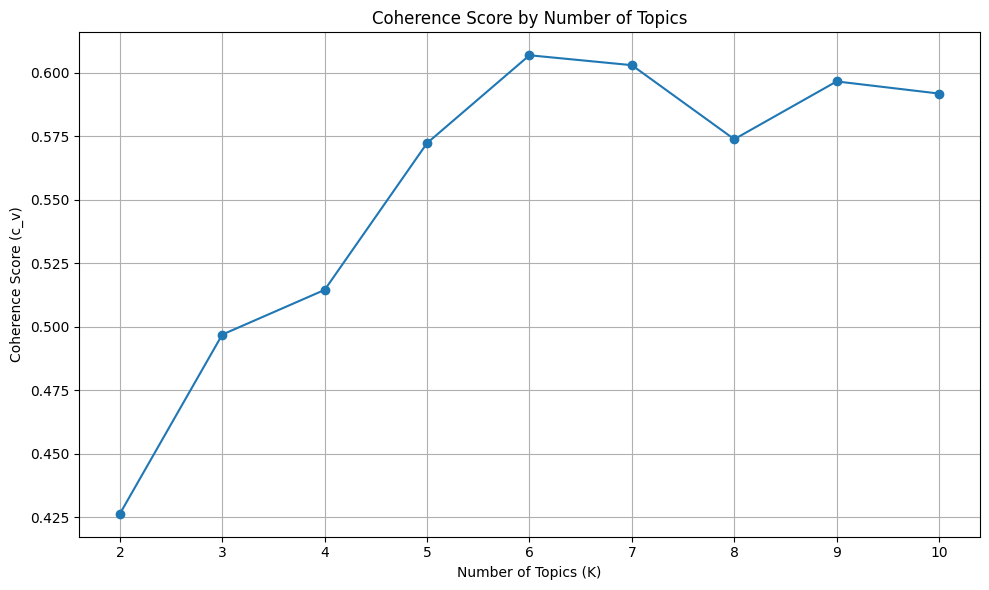

Best K: 6
Best coherence score: 0.6070


In [28]:
# =========================================
# 12. Experiment: Find Optimal K (Coherence)
# =========================================
# Evaluate coherence across candidate topic counts

df_reload = pd.read_pickle("nlp_ready_corpus.pkl")

# Ensure token lists are lists
if isinstance(df_reload['nouns_clean'].iloc[0], str):
    import ast
    df_reload['nouns_clean'] = df_reload['nouns_clean'].apply(ast.literal_eval)

texts = df_reload['nouns_clean'].tolist()

id2word = gensim.corpora.Dictionary(texts)
id2word.filter_extremes(no_below=15, no_above=0.4)
corpus = [id2word.doc2bow(text) for text in texts]

start = 2
limit = 10
step = 1

coherence_values = []

for num_topics in range(start, limit + 1, step):
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=100,
        chunksize=200,
        passes=10,
        alpha='auto'
    )

    coherence_model = CoherenceModel(
        model=model,
        texts=texts,
        dictionary=id2word,
        coherence='c_v'
    )

    coherence_values.append(coherence_model.get_coherence())

x = list(range(start, limit + 1, step))

plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score by Number of Topics")
plt.xticks(x)
plt.grid(True)
plt.tight_layout()
plt.savefig("Optimal_K_Graph.png", dpi=300)
plt.show()

best_k = x[int(np.argmax(coherence_values))]
best_score = float(max(coherence_values))

print(f"Best K: {best_k}")
print(f"Best coherence score: {best_score:.4f}")



13. Train Final LDA Model & Coherence

In [29]:
# =========================================
# 13. Train Final LDA Model & Coherence
# =========================================
# Train LDA using the selected K

num_topics = 6

lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    chunksize=200,
    passes=10,
    alpha='auto'
)

coherence_model = CoherenceModel(
    model=lda_model,
    texts=texts,
    dictionary=id2word,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print(f"Coherence score (K={num_topics}): {coherence_score:.4f}")


Coherence score (K=6): 0.6070


14. Top Keywords per Topic

In [30]:
# =========================================
# 14. Top Keywords per Topic
# =========================================
# Print top terms per topic for interpretation

for idx, topic in lda_model.print_topics(num_words=20):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.030*"국민" + 0.024*"민주당" + 0.022*"후보" + 0.017*"이재명" + 0.014*"정부" + 0.014*"대통령" + 0.014*"민생" + 0.011*"공약" + 0.011*"대선" + 0.009*"성장" + 0.007*"기업" + 0.007*"국회" + 0.007*"강조" + 0.006*"국가" + 0.006*"산업" + 0.006*"정치" + 0.006*"이날" + 0.005*"시장" + 0.005*"확대" + 0.005*"문제"
Topic 1: 0.087*"청년" + 0.076*"신청" + 0.057*"경기도" + 0.035*"분기" + 0.027*"거주" + 0.024*"사용" + 0.022*"화폐" + 0.020*"주민" + 0.020*"등록" + 0.013*"경기" + 0.013*"기간" + 0.012*"대상자" + 0.011*"접수" + 0.010*"제출" + 0.010*"일자리" + 0.009*"카드" + 0.009*"자동" + 0.008*"모바일" + 0.008*"온라인" + 0.008*"별도"
Topic 2: 0.028*"복지" + 0.022*"사회" + 0.021*"제도" + 0.019*"가구" + 0.017*"서울" + 0.015*"보장" + 0.014*"연구" + 0.014*"효과" + 0.011*"시장" + 0.010*"안심" + 0.010*"서울시" + 0.008*"결과" + 0.008*"기초" + 0.008*"분석" + 0.008*"생활" + 0.008*"교수" + 0.007*"수급" + 0.007*"실험" + 0.007*"조사" + 0.007*"시범"
Topic 3: 0.058*"민생" + 0.055*"회복" + 0.039*"소비" + 0.033*"신청" + 0.032*"쿠폰" + 0.027*"사용" + 0.011*"상품권" + 0.010*"음성군" + 0.009*"매출" + 0.008*"센터" + 0.007*"카드" + 0.007*"음성" + 0.007*"군민" + 0.007*"가맹점

15. Save pyLDAvis Output

In [31]:
# =========================================
# 15. Save pyLDAvis Output
# =========================================

vis = pyLDAvis.gensim_models.prepare(
    lda_model, corpus, id2word, sort_topics=False
)

pyLDAvis.save_html(vis, "lda_result.html")

print("pyLDAvis saved: lda_result.html")


pyLDAvis saved: lda_result.html


16. Assign Topic Labels & Save Dataset

In [32]:
# =========================================
# 16. Assign Topic Labels & Save
# =========================================
# Assign descriptive labels based on top keywords.

topic_labels = {
    0: "National Politics & Election Discourse (Parties, Candidates, UBI Debate)",
    1: "Youth Basic Income Application & Administration (Gyeonggi)",
    2: "Urban Welfare Policy & Research (Seoul, Social Security, Experiments)",
    3: "Local Economic Recovery & Consumption Stimulus (Coupons, Budget, Livelihood)",
    4: "Disaster Relief & Recovery Support (Damage, Wildfire, Emergency Aid)",
    5: "Rural/Regional Basic Income Pilots (Depopulation, Farming Communities)"
}

def assign_topic(ldamodel, corpus):
    rows = []
    for topics in ldamodel.get_document_topics(corpus, minimum_probability=0):
        topics = sorted(topics, key=lambda x: x[1], reverse=True)
        topic_num, prop = topics[0]

        if prop < 0.3:
            rows.append(['Mixed', round(prop, 4)])
        else:
            rows.append([topic_num, round(prop, 4)])

    return pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution'])

df_topic = assign_topic(lda_model, corpus)
df_final = pd.concat([df_topic, df.reset_index(drop=True)], axis=1)

df_final['Topic_Label'] = df_final['Dominant_Topic'].apply(
    lambda x: "Mixed" if x == 'Mixed' else topic_labels[x]
)

df_final.to_pickle("Final_Basic_Income_Analysis_V2.pkl")

print(f"Topic dataset saved: Final_Basic_Income_Analysis_V2.pkl ({len(df_final)} rows)")


Topic dataset saved: Final_Basic_Income_Analysis_V2.pkl (8930 rows)


17. Load & Merge (Topic + Tokens)

In [33]:
# =========================================
# 17. Load & Merge (Topic + Tokens)
# =========================================
# Merge topic outputs with token lists using doc_id

df_final = pd.read_pickle("Final_Basic_Income_Analysis_V2.pkl")
df_day2 = pd.read_pickle("nlp_ready_corpus.pkl")

df_final['doc_id'] = df_final['doc_id'].astype(int)
df_day2['doc_id'] = df_day2['doc_id'].astype(int)

cols_to_drop = ['nouns', 'predicates']
df_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns], errors='ignore')

df_final = df_final.merge(
    df_day2[['doc_id', 'nouns', 'predicates']],
    on='doc_id',
    how='left'
)

def fix_list(x):
    return x if isinstance(x, list) else []

df_final['nouns'] = df_final['nouns'].apply(fix_list)
df_final['predicates'] = df_final['predicates'].apply(fix_list)

print(f"Merged dataset shape: {df_final.shape}")


Merged dataset shape: (8930, 27)


18. Define Custom Sentiment Words

In [34]:
# =========================================
# 18. Define Custom Sentiment Words
# =========================================
# Define domain-specific sentiment words for policy discourse

added_pos = [
    '확정', '체결', '완료', '혁신', '돌파', '유치', '급증',
    '지원', '혜택', '확대', '지급', '성공', '활성화', '도입',
    '추진', '협력', '강화', '보장', '기회', '회복', '달성', '해결',
   '선정', '개선', '환영', '통과', '성과', '인상', '마련'
]

added_neg = [
    '논란', '우려', '반대', '비판', '삭감', '갈등', '실패',
    '축소', '부작용', '위기', '불만', '차별', '소외', '포퓰리즘',
    '낭비', '혈세', '적자', '부담', '악화', '지연', '거부', '항의',
    '피해', '고갈', '세금폭탄', '인플레', '부채', '역효과'
]


print(f"Custom words: {len(added_pos)} positive, {len(added_neg)} negative")


Custom words: 29 positive, 28 negative


19. Build Sentiment Dictionary (KNU + Custom Words)

In [35]:
# =========================================
# 19. Build Sentiment Dictionary (KNU + Custom + Bias Removal)
# =========================================
# Load base lexicon, add domain words, and remove policy-framing bias terms

senti_data = pd.read_json("SentiWord_info.json")
senti_dict = {}
for _, row in senti_data.iterrows():
    word = str(row['word_root']).split('/')[0]
    score = int(row['polarity'])
    senti_dict[word] = score

for word in added_pos:
    senti_dict[word] = 2

for word in added_neg:
    senti_dict[word] = -2

# Remove '안심' variants to avoid policy-name framing bias
for w in ['안심', '안심 되는', '안심찮', '안심하다']:
    senti_dict.pop(w, None)
print(f"Sentiment dictionary size: {len(senti_dict)}")


Sentiment dictionary size: 11464


20. Calculate Sentiment Scores

In [38]:
# =========================================
# 20. Calculate Sentiment Scores
# =========================================
# Compute document-level sentiment and matched-token counts

sentiment_scores = []
match_counts = []

for nouns, preds in zip(df_final['nouns'], df_final['predicates']):
    pos_score = 0
    neg_score = 0
    cnt = 0

    all_tokens = nouns + preds

    for w in all_tokens:
        if w in senti_dict:
            score = senti_dict[w]
            cnt += 1
            if score > 0:
                pos_score += score
            elif score < 0:
                neg_score += abs(score)

    sentiment_scores.append(pos_score - neg_score)
    match_counts.append(cnt)

df_final['Sentiment_Score'] = sentiment_scores
df_final['match_counts'] = match_counts

print("Sentiment scoring completed")


Sentiment scoring completed


21. Normalize Scores & Summary Statistics

In [39]:
# =========================================
# 21. Normalize Scores & Summary Statistics
# =========================================
# Normalize sentiment by matched tokens and summarize by topic


df_final['Sentiment_Score_norm'] = df_final.apply(
    lambda x: x['Sentiment_Score'] / x['match_counts'] if x['match_counts'] > 0 else 0,
    axis=1
)

total = len(df_final)
neutral = int((df_final['match_counts'] == 0).sum())
active = total - neutral

print(f"Total articles: {total}")
print(f"Matched sentiment: {active}")
print(f"No-match (neutral): {neutral}")

df_final.groupby('Topic_Label')['Sentiment_Score_norm'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)


Total articles: 8930
Matched sentiment: 8810
No-match (neutral): 120


,mean,count
Topic_Label,,
"Urban Welfare Policy & Research (Seoul, Social Security, Experiments)",0.944202,887
Youth Basic Income Application & Administration (Gyeonggi),0.871810,913
"Rural/Regional Basic Income Pilots (Depopulation, Farming Communities)",0.792589,2826
"Local Economic Recovery & Consumption Stimulus (Coupons, Budget, Livelihood)",0.701396,1675
Mixed,0.520806,78
"National Politics & Election Discourse (Parties, Candidates, UBI Debate)",0.494032,1334
"Disaster Relief & Recovery Support (Damage, Wildfire, Emergency Aid)",-0.012021,1217


22. Save Final Dataset

In [40]:
# =========================================
# 22. Save Final Dataset
# =========================================
# Export final dataset for downstream analysis


save_cols = [
    'doc_id', 'year', 'title',
    'Topic_Label', 'Dominant_Topic',
    'Sentiment_Score', 'Sentiment_Score_norm', 'match_counts'
]

if '일자' in df_final.columns:
    df_final = df_final.rename(columns={'일자': 'date'})
    save_cols.append('date')
elif 'date' in df_final.columns:
    save_cols.append('date')

df_final[save_cols].to_pickle("Final_Dataset_Complete.pkl")
df_final[save_cols].to_excel("Final_Dataset_Complete.xlsx", index=False)

print("Final dataset saved")


Final dataset saved


**Trend & Event Analysis + Visualization**

23. Load Dataset & Prepare Date Columns

In [41]:
# =========================================
# 23. Load Dataset & Prepare Date Columns
# =========================================
# Format Dates & Build Monthly Time Series

df = pd.read_pickle("Final_Dataset_Complete.pkl")

df['date_dt'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
df = df.dropna(subset=['date_dt'])

df['month'] = df['date_dt'].dt.to_period('M')

print(f"Loaded rows: {len(df)}")
print(f"Date range: {df['date_dt'].min().date()} to {df['date_dt'].max().date()}")


Loaded rows: 8930
Date range: 2022-01-01 to 2025-12-12


24. Trend Analysis (Pearson Correlation)

In [42]:
# =========================================
# 24. Trend Analysis (Pearson Correlation)
# =========================================
# Test for a linear trend over time

monthly_sentiment = df.groupby('month')['Sentiment_Score_norm'].mean().reset_index()
monthly_sentiment['time_index'] = range(len(monthly_sentiment))

corr_coef, p_val = stats.pearsonr(monthly_sentiment['time_index'], monthly_sentiment['Sentiment_Score_norm'])

print(f"Correlation (r): {corr_coef:.4f}")
print(f"P-value: {p_val:.4e}")


Correlation (r): 0.2357
P-value: 1.0685e-01


25. Trend Analysis (Spearman Correlation)

In [43]:
# =========================================
# 25. Trend Analysis (Spearman Correlation)
# =========================================
# Test for a monotonic trend (robust to non-linear fluctuations)

r_s, p_s = stats.spearmanr(
    monthly_sentiment['time_index'],
    monthly_sentiment['Sentiment_Score_norm']
)

print(f"Spearman r: {r_s:.4f}")
print(f"Spearman p-value: {p_s:.4e}")


Spearman r: 0.3009
Spearman p-value: 3.7685e-02


26. Event Analysis: Presidential Election Cycles vs Non-Election Periods

In [44]:
# =========================================
# 26. Event Analysis: Presidential Election Cycles vs Non-Presidential Periods
# =========================================
# Compare sentiment during presidential election windows vs non-election periods

from scipy import stats

# Ensure datetime column exists
target_col = 'date' if 'date' in df.columns else '일자'
df['date_dt'] = pd.to_datetime(df[target_col].astype(str), errors='coerce')

# Presidential election cycles (2022, 2025)
mask_presidential = (
    ((df['date_dt'] >= '2022-01-01') & (df['date_dt'] <= '2022-06-30')) |
    ((df['date_dt'] >= '2024-12-01') & (df['date_dt'] <= '2025-06-03'))
)

group_presidential = df[mask_presidential]['Sentiment_Score_norm'].dropna()
group_non_presidential = df[~mask_presidential]['Sentiment_Score_norm'].dropna()

# T-test
t_stat, p_val_t = stats.ttest_ind(
    group_presidential,
    group_non_presidential,
    equal_var=False
)

# Output (labels updated only)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val_t:.4e}")
print(f"Mean Score (Presidential Election Cycles (2022, 2025)): {group_presidential.mean():.4f}")
print(f"Mean Score (Non-Presidential Periods): {group_non_presidential.mean():.4f}")



T-statistic: -6.6990
P-value: 2.2871e-11
Mean Score (Presidential Election Cycles (2022, 2025)): 0.5761
Mean Score (Non-Presidential Periods): 0.6733


27. Prepare Data for Final Figures

In [45]:
# =========================================
# 27. Prepare Data for Final Figures
# =========================================
# Create rolling averages and yearly topic counts


monthly_sentiment = monthly_sentiment.copy()
monthly_sentiment['month_ts'] = monthly_sentiment['month'].dt.to_timestamp()
monthly_sentiment = monthly_sentiment.sort_values('month_ts')
monthly_sentiment['rolling_mean_3m'] = monthly_sentiment['Sentiment_Score_norm'].rolling(window=3, min_periods=1).mean()

df_plot = df.copy()
df_plot['year_from_date'] = df_plot['date_dt'].dt.year

yearly_topics = df_plot.groupby(['year_from_date', 'Topic_Label']).size().reset_index(name='count')

top_5_topics = df_plot['Topic_Label'].value_counts().nlargest(5).index
final_yearly_data = yearly_topics[yearly_topics['Topic_Label'].isin(top_5_topics)].copy()

pivot = final_yearly_data.pivot_table(
    index='year_from_date',
    columns='Topic_Label',
    values='count',
    fill_value=0
).sort_index()


28. Plot Figures & Save

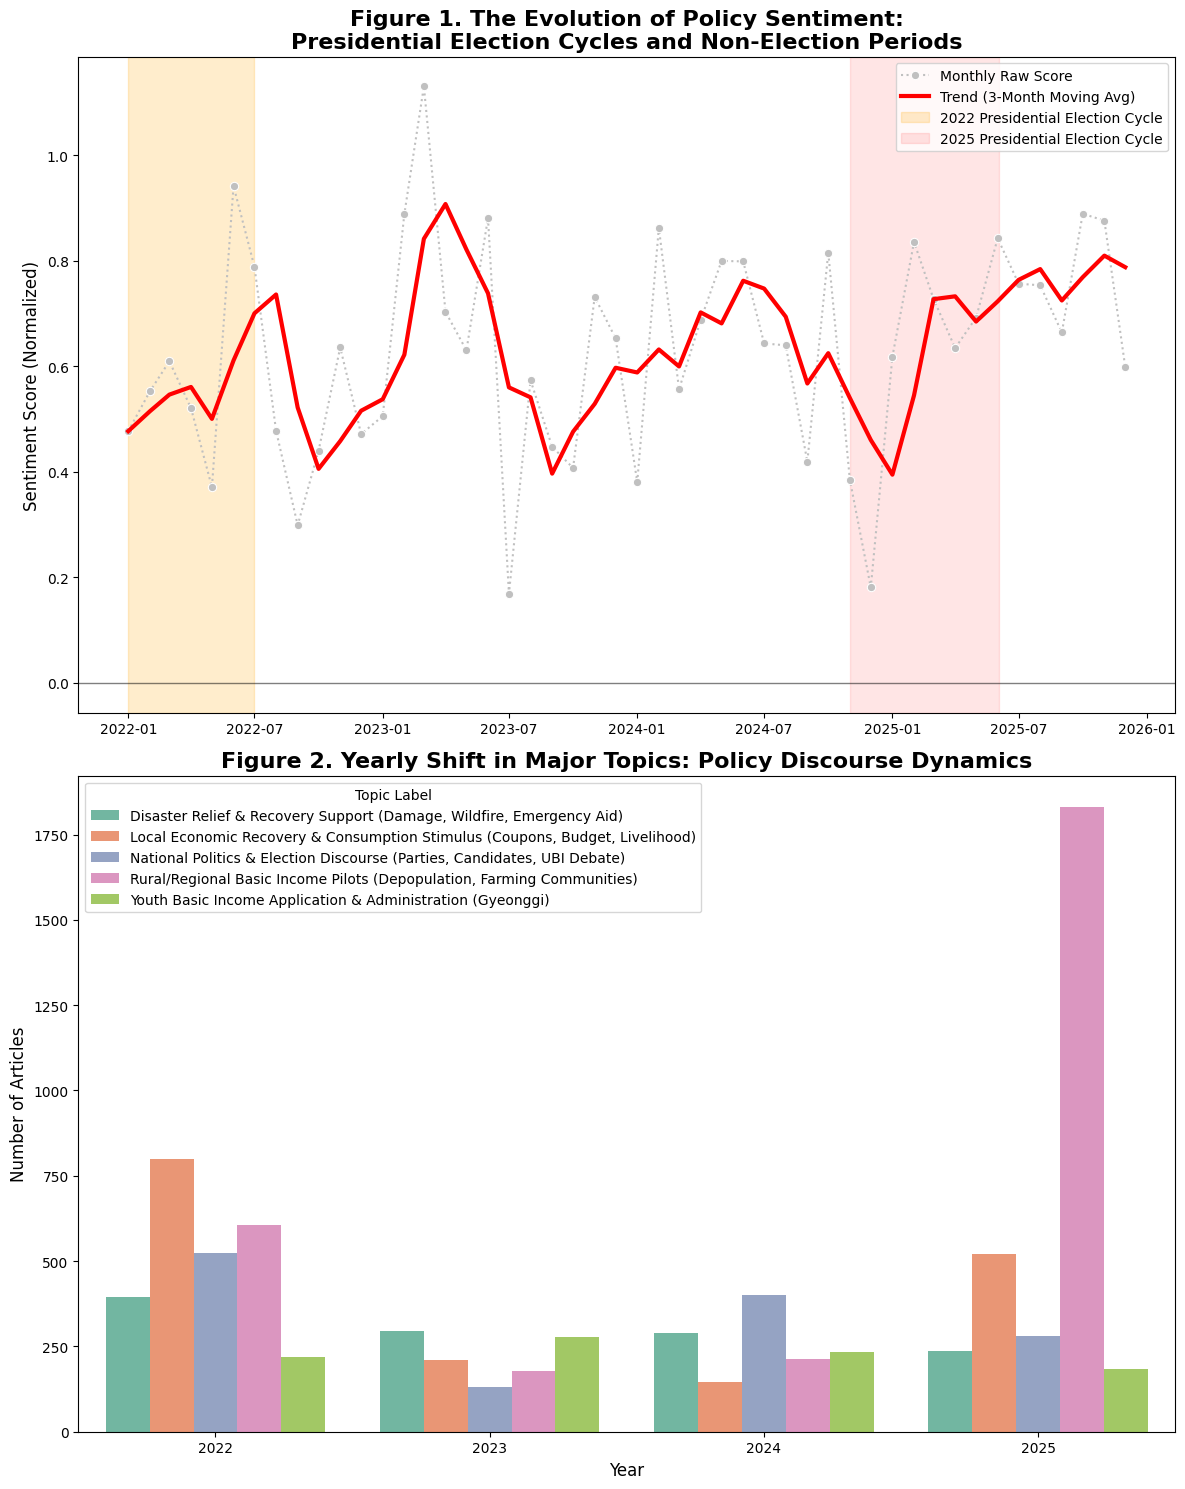

In [60]:
# ==========================================
# 28. Final Visualization
# ==========================================
# Plot sentiment trend and topic distribution over time

plt.figure(figsize=(12, 15))

# Figure 1: Sentiment Trend
plt.subplot(2, 1, 1)

sns.lineplot(
    data=monthly_sentiment,
    x='month_ts',
    y='Sentiment_Score_norm',
    marker='o',
    color='silver',
    linestyle=':',
    label='Monthly Raw Score'
)

sns.lineplot(
    data=monthly_sentiment,
    x='month_ts',
    y='rolling_mean_3m',
    color='red',
    linewidth=3,
    label='Trend (3-Month Moving Avg)'
)

plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-06-30'),
            color='orange', alpha=0.2, label='2022 Presidential Election Cycle')

plt.axvspan(pd.Timestamp('2024-11-01'), pd.Timestamp('2025-06-03'),
            color='red', alpha=0.1, label='2025 Presidential Election Cycle')

plt.axhline(0, color='black', linewidth=1, alpha=0.5)

plt.title(
    'Figure 1. The Evolution of Policy Sentiment:\nPresidential Election Cycles and Non-Election Periods',
    fontsize=16, fontweight='bold'
)

plt.ylabel('Sentiment Score (Normalized)', fontsize=12)
plt.xlabel('')
plt.legend(loc='upper right', frameon=True)

# Figure 2: Topic Distribution
plt.subplot(2, 1, 2)

sns.barplot(
    data=final_yearly_data,
    x='year_from_date',
    y='count',
    hue='Topic_Label',
    palette='Set2'
)

plt.title(
    'Figure 2. Yearly Shift in Major Topics: Policy Discourse Dynamics',
    fontsize=16, fontweight='bold'
)

plt.ylabel('Number of Articles', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Topic Label', loc='upper left', frameon=True)

plt.tight_layout()
plt.savefig('Final_Graph_Evolution_Clean.png', dpi=300, bbox_inches='tight')
plt.show()

